In [119]:
import numpy as np
import skimage.io as io
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pykalman import KalmanFilter
%matplotlib notebook

In [335]:
class TestDetectors:
    
    # This method passes a small sequence of input images to a family detectors
    # if they need to be initialized to track a target object
    # Parameters:
    # (1) detectorFamily: a list of detector objects to test
    # (2) inputImgs or inputImgNames: 
    #       One of these must not be None
    #       inputImgs is input sequence of image data as a list
    #       inputImgNames is input sequence of image filenames as a list
    @staticmethod
    def prepareDetectors(detectorFamily, inputImgs=None, inputImgNames=None):
        if inputImgs is not None:
            TestDetectors._prepareDetectorsImgs(detectorFamily, inputImgs)
        else:
            TestDetectors._prepareDetectorsNames(detectorFamily, inputImgNames)
        
    @staticmethod
    def _prepareDetectorsImgs(detectorFamily, inputImgs):
        for detector in detectorFamily:
            for i, inputImg in enumerate(inputImgs):
                detector.prepare(i, inputImg)

    @staticmethod
    def _prepareDetectorsNames(detectorFamily, inputImgNames):
        for i, inputImgName in enumerate(inputImgNames):
            inputImg = io.imread(inputImgName)
            for detector in detectorFamily:
                detector.prepare(i, inputImg)
    
    # This method is one of two tests; assumes detector returns coordinate immediately
    # but blocks itself for some number of subsequent frames 
    # Parameters:
    # (1) detectorFamily: a list of detector objects to test
    # (2) fps: frames per second of input sequence
    # (3) inputGT: the ground truth coordinates of the tracked object (optional)
    # (4) inputImgs or inputImgNames: 
    #       One of these must not be None
    #       inputImgs is input sequence of image data as a list
    #       inputImgNames is input sequence of image filenames as a list
    @staticmethod
    def testDetectorsDelayForward(detectorFamily, fps, inputGT=None, inputImgs=None, inputImgNames=None):
        readImgLambda = lambda x: io.imread(x) if inputImgs is None else x
        imgList = inputImgs if inputImgNames is None else inputImgNames
        T_s = 1/(1.*fps)
        
        # for each detector in detector family, store an array (to be modified)
        # where each element in the array indicates if the detector should be run
        # on the frame with corresponding index
        detectorThreadBlocked = {detector.name(): np.ones(len(imgList), dtype=np.int32) for detector in detectorFamily}
        
        # The return of the test
        resultsDf = pd.DataFrame(columns=[detector.name() for detector in detectorFamily] + ['GT'])
        
        # Kalman filters per detector
        kf = {detector.name(): KF() for detector in detectorFamily}

        # outer loop over images so that we load an image once and share between detectors
        for i, img in enumerate(imgList):
            img = readImgLambda(img)
            
            # results are the Kalman filter predictions
            resultDict = {detector.name(): 0 for detector in detectorFamily}
            resultDict['GT'] = inputGT[i] if inputGT is not None else None
            
            # inner loop over detectors in family
            for detector in detectorFamily:
                # The object detector observation
                y = None
                
                # The Kalman filter corrected estimate
                x_k_k = None
                
                # The Kalman filter prediction
                x_kplus_k = None
                
                # In forward delay, let the detector find the newest object location,
                # block the detector from being called for a number of frames equal
                # to the ceiling of the fraction of detector runtime to T_s=1/fps
                if detectorThreadBlocked[detector.name()][i] == 1:
                    start = time()
                    y = detector.detect(i, img)
                    runtime = time()-start
                    delayedFrames = int(np.ceil(runtime/T_s))
                    detectorThreadBlocked[detector.name()][i:i+delayedFrames] = 0
                
                #import pdb
                #pdb.set_trace()
                # We can only correct if 'y' has valid data,
                # and more importantly, we can only correct if the detector was not blocked
                if y is not None:
                    x_k_k = kf[detector.name()].correct(i, y)
                
                # We can always predict; This is the 'filtering' in Kalman filtering
                x_kplus_k = kf[detector.name()].predict(i)
                
                # Save the result for this detector
                resultDict[detector.name()] = x_kplus_k.data[0:2]
                
            resultsDf.loc[i+1] = resultDict
        
        return resultsDf
                 
    # This method is one of two tests; assumes detector returns coordinate after some
    # number of frames. This creates an information delay
    # Parameters:
    # (1) detectorFamily: a list of detector objects to test
    # (2) fps: frames per second of input sequence
    # (3) inputGT: the ground truth coordinates of the tracked object (optional)
    # (4) inputImgs or inputImgNames: 
    #       One of these must not be None
    #       inputImgs is input sequence of image data as a list
    #       inputImgNames is input sequence of image filenames as a list
    @staticmethod
    def testDetectorsDelayBackward(detectorFamily, fps, inputGT, inputImgs=None, inputImgNames=None):
        readImgLambda = lambda x: io.imread(x) if inputImgs is None else x
        imgList = inputImgs if inputImgNames is None else inputImgNames
        T_s = 1/(1.*fps)
        
        # for each detector in detector family, store an array (to be modified)
        # where each element in the array indicates if the detector should be run
        # on the frame with corresponding index
        detectorThreadBlocked = {detector.name(): np.ones(len(imgList), dtype=np.int32) for detector in detectorFamily}
        detectorResult = {detector.name(): None for detector in detectorFamily}

        # The return of the test
        resultsDf = pd.DataFrame(columns=[detector.name() for detector in detectorFamily] + ['GT'])
        
        # Kalman filters per detector
        kf = {detector.name(): KF() for detector in detectorFamily}

        # outer loop over images so that we load an image once and share between detectors
        for i, img in enumerate(imgList):
            img = readImgLambda(img)
            
            # results are the Kalman filter predictions
            resultDict = {detector.name(): 0 for detector in detectorFamily}
            resultDict['GT'] = inputGT[i] if inputGT is not None else None
            
            # inner loop over detectors in family
            for detector in detectorFamily:
                # The object detector observation, which may or may not have arrived
                y = detectorResult[detector.name()] if detectorThreadBlocked[detector.name()][i] == 1 else None
                
                # The Kalman filter corrected estimate
                x_k_k = None
                
                # The Kalman filter prediction
                x_kplus_k = None
                
                # We can only correct if detector result has arrived
                if y is not None:
                    x_k_k = kf[detector.name()].correct(i, y)
                
                # We can always predict; This is the 'filtering' in Kalman filtering
                x_kplus_k = kf[detector.name()].predict(i)
                
                # Save the result for this detector
                resultDict[detector.name()] = x_kplus_k.data[0:2]
                
                # In backward delay, let the detector find the newest object location,
                # block the detector from being called for a number of frames equal
                # to the ceiling of the fraction of detector runtime to T_s=1/fps,
                # and show the Kalman filter the result only after those frames have passed
                if detectorThreadBlocked[detector.name()][i] == 1:
                    start = time()
                    detectorResult[detector.name()] = detector.detect(i, img)
                    runtime = time()-start
                    delayedFrames = int(np.ceil(runtime/T_s))
                    detectorThreadBlocked[detector.name()][i:i+delayedFrames] = 0
                
            resultsDf.loc[i+1] = resultDict
        
        return resultsDf

In [336]:
# Constant acceleration Kalman filter
class KF:
    def __init__(self):
        self.Transition_Matrix=np.array([[1,0,1,0,0.5,0],
                                         [0,1,0,1,0,0.5],
                                         [0,0,1,0,1,0],
                                         [0,0,0,1,0,1],
                                         [0,0,0,0,1,0],
                                         [0,0,0,0,0,1]], dtype=np.float32)
        self.Observation_Matrix=np.array([[1,0,0,0,0,0],
                                          [0,1,0,0,0,0]], dtype=np.float32)

        xinit=0
        yinit=0
        vxinit=0
        vyinit=0
        axinit=0
        ayinit=0
        self.initstate=np.array([xinit,yinit,vxinit,vyinit,axinit,ayinit], dtype=np.float32)
        self.initcovariance=1.0e-3*np.eye(6)
        self.transistionCov=1.0e-4*np.eye(6)
        self.observationCov=1.0e-1*np.eye(2)
        
        self.recentstate = self.initstate
        self.recentcovariance = self.initcovariance
        
        self.kf=KalmanFilter(transition_matrices=self.Transition_Matrix,
                observation_matrices=self.Observation_Matrix,
                initial_state_mean=self.initstate,
                initial_state_covariance=self.initcovariance,
                transition_covariance=self.transistionCov,
                observation_covariance=self.observationCov)
    
    def predict(self, i):
        self.recentstate, self.recentcovariance = self.kf.filter_update(self.recentstate, self.recentcovariance)
        #print self.recentstate
        return self.recentstate
    
    def correct(self, i, y):
        #import pdb
        #pdb.set_trace()
        self.recentstate, self.recentcovariance = self.kf.filter_update(self.recentstate, self.recentcovariance, y)
        return self.recentstate

In [337]:
class Detector:
    def __init__(self):
        return
    
    def prepare(self, i, img):
        return
    
    def detect(self, i, img):
        return
    
    def name(self):
        return 'BaseClass'

In [338]:
class MOGDetector(Detector):
    def __init__(self, d, threshold):    
        history = 10
        bgThresh = threshold
        shadows = True
        self.bgs = cv2.createBackgroundSubtractorMOG2(history,bgThresh,shadows)
        self.d = d
        
        self.detectorName = 'mog_{}'.format(d)
        
    def prepare(self, i, img):
        dsize = img.shape[1]/self.d, img.shape[0]/self.d
        imgResized = cv2.resize(img, dsize=dsize)
        self.bgs.apply(img, learningRate=-1)
        
    def detect(self, i, img):
        dsize = img.shape[1]/self.d, img.shape[0]/self.d
        imgResized = cv2.resize(img, dsize=dsize) 
        foremat=self.bgs.apply(imgResized, learningRate=1/(1.*(i+5)))
        ret,thresh = cv2.threshold(foremat,127,255,0)
        ret,labeledImg, stats, centroids = cv2.connectedComponentsWithStats(thresh)
        m = None
        if len(centroids) > 1:
            m = centroids[np.argsort(stats[:, cv2.CC_STAT_AREA])[-2]]
            m = m*self.d
        return m
            
    def name(self):
        return self.detectorName

In [339]:
def testTennisMog(start, end, fps, D, threshold):
    start = max(start, 10)
    end = max(end, start+1)
    tennisGT = pd.read_csv('TennisHD180/ground_truth.csv', header=None)

    tennisPrepareImgNames = ['TennisHD180/bouncy{:03}.jpg'.format(i) for i in range(0, start)]
    tennisTestImgNames = ['TennisHD180/bouncy{:03}.jpg'.format(i) for i in range(start, end)]

    mogDetectorFamily = [MOGDetector(d+1, threshold) for d in range(D)]

    TestDetectors.prepareDetectors(mogDetectorFamily, inputImgNames=tennisPrepareImgNames)

    forwardDf = TestDetectors.testDetectorsDelayForward(mogDetectorFamily, 
                                                        fps,
                                                        np.array(tennisGT[start-10:end-10]), 
                                                        inputImgNames=tennisTestImgNames)
    backwardDf = TestDetectors.testDetectorsDelayBackward(mogDetectorFamily, 
                                                          fps, 
                                                          np.array(tennisGT[start-10:end-10]), 
                                                          inputImgNames=tennisTestImgNames)
    return forwardDf, backwardDf

In [241]:
def testTennisMogPrepare(start, end, fps, D, threshold):
    start = max(start, 10)
    end = max(end, start+1)
    tennisGT = pd.read_csv('TennisHD180/ground_truth.csv', header=None)

    tennisPrepareImgNames = ['TennisHD180/bouncy{:03}.jpg'.format(i) for i in range(0, start)]
    tennisTestImgNames = ['TennisHD180/bouncy{:03}.jpg'.format(i) for i in range(start, end)]

    mogDetectorFamily = [MOGDetector(d+1, threshold) for d in range(D)]

    TestDetectors.prepareDetectors(mogDetectorFamily, inputImgNames=tennisPrepareImgNames)

    img = io.imread(tennisTestImgNames[3])
    foremat=mogDetectorFamily[0].bgs.apply(img, learningRate=0)
    ret,thresh = cv2.threshold(foremat,127,255,0)
    ret,labeledImg, stats, centroids = cv2.connectedComponentsWithStats(thresh)
    print centroids[np.argsort(stats[:, cv2.CC_STAT_AREA])[-2]]

    plt.figure()
    plt.imshow(foremat)

In [340]:
_forwardDf, _backwardDf = testTennisMog(10, 189, 60., 2, 10.)

[129.45416667  96.72916667]


<IPython.core.display.Javascript object>


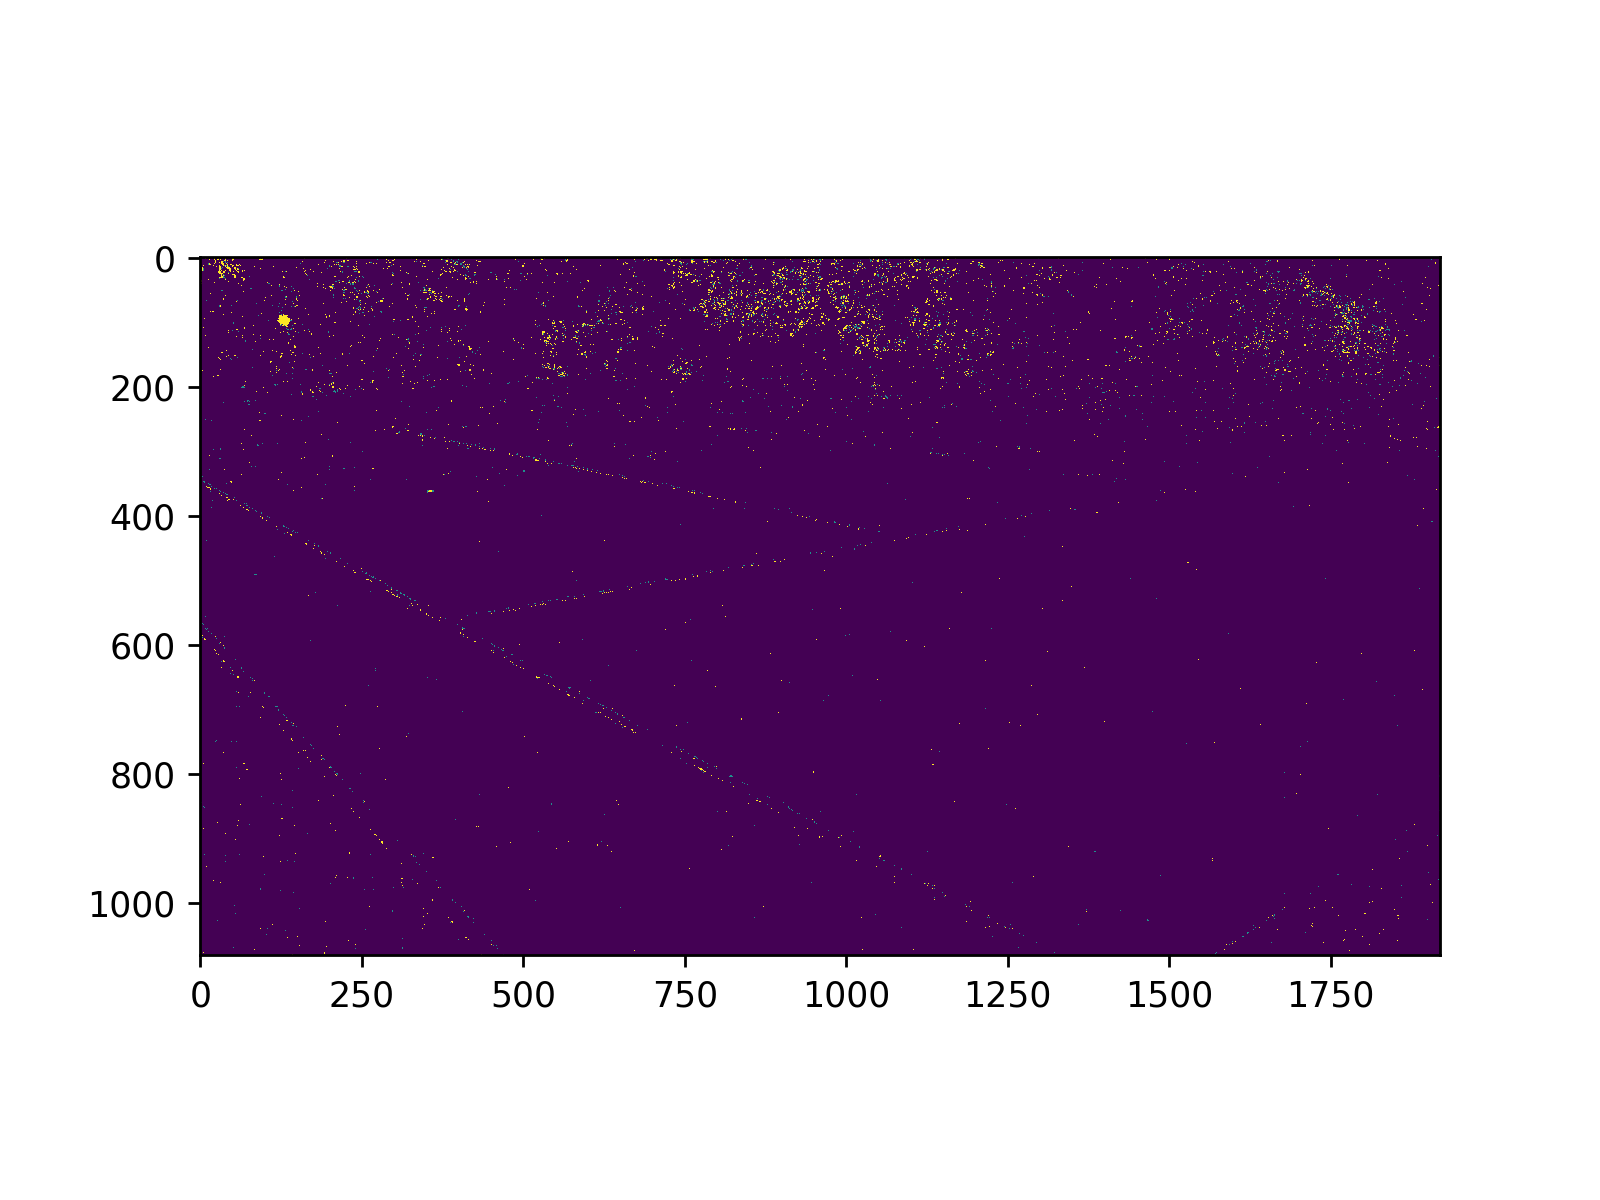

In [357]:
testTennisMogPrepare(10, 189, 60., 2, 10.)

<IPython.core.display.Javascript object>


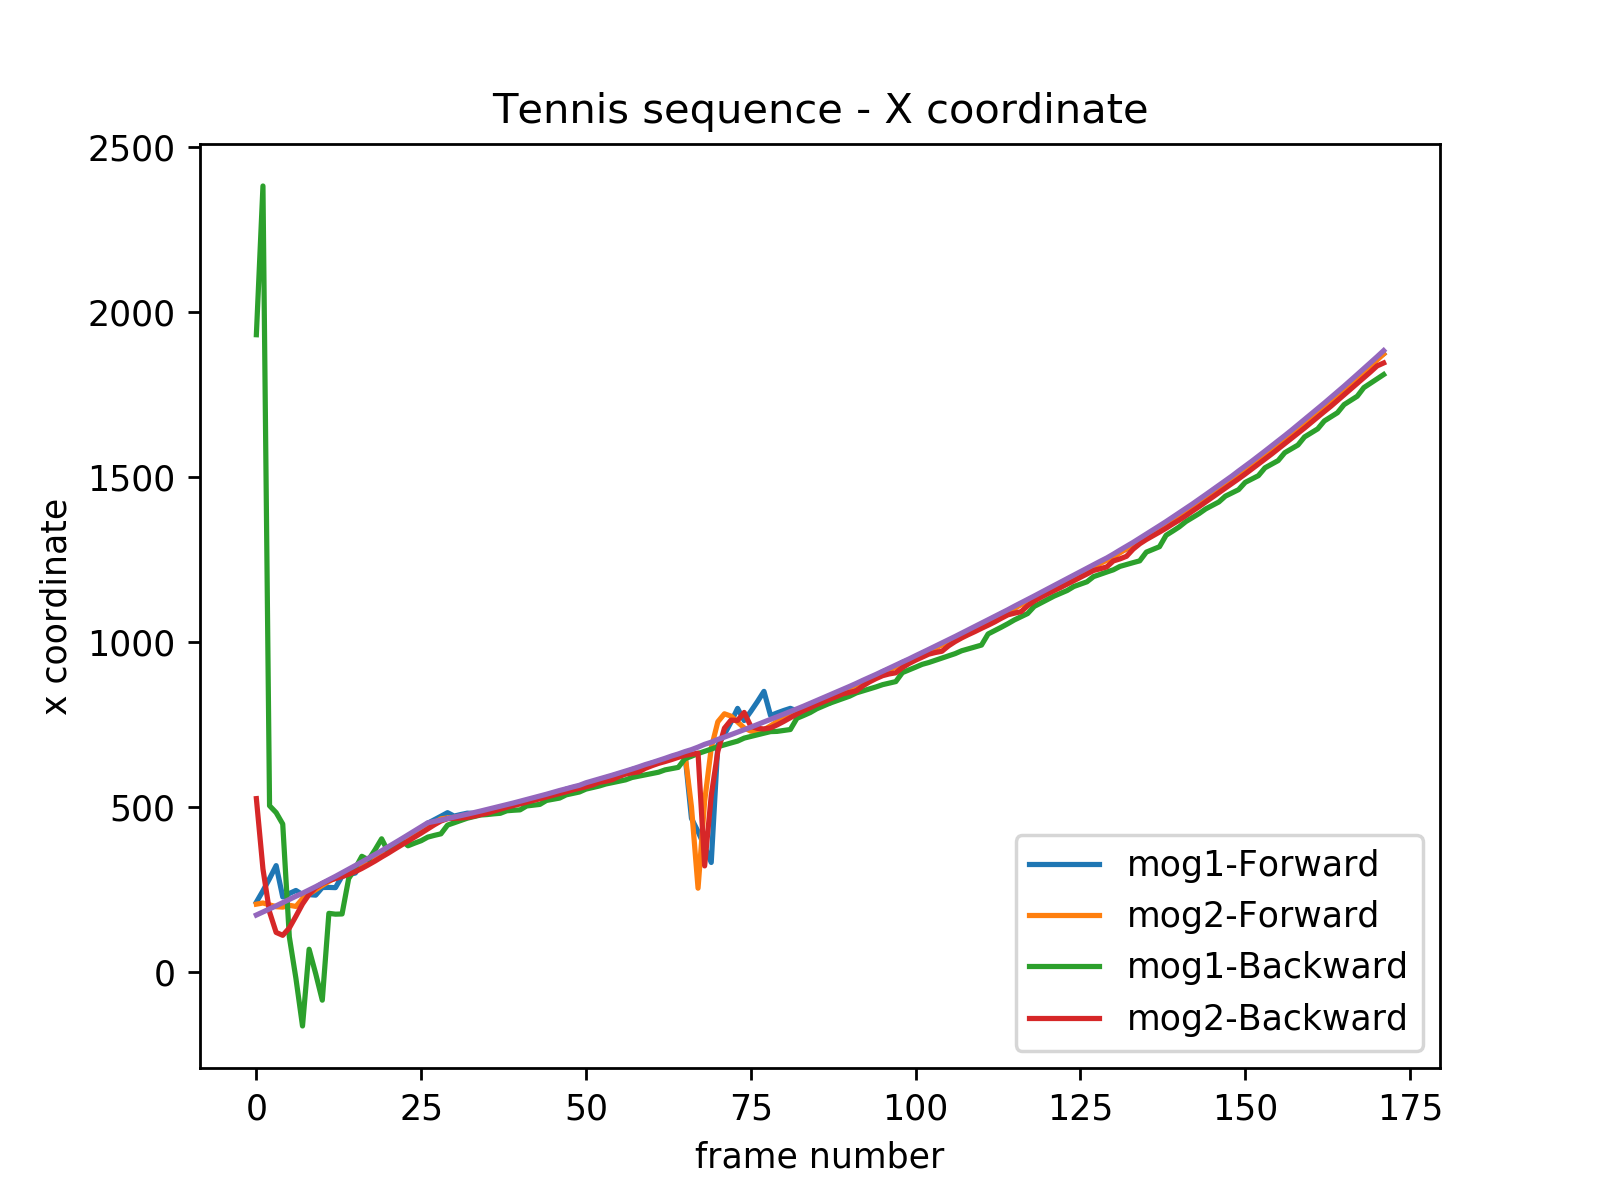

Text(0.5,0,'frame number')

In [358]:
_backwardF = _backwardDf[7:]
_forwardF = _forwardDf[7:]
plt.figure()

x_y = np.concatenate(_forwardF['mog_1'].values).reshape(len(_forwardF['mog_1'].values), 2)
plt.plot(x_y[:,0], label='mog1-Forward')

x_y = np.concatenate(_forwardF['mog_2'].values).reshape(len(_forwardF['mog_2'].values), 2)
plt.plot(x_y[:,0], label='mog2-Forward')

x_y = np.concatenate(_backwardF['mog_1'].values).reshape(len(_backwardF['mog_1'].values), 2)
plt.plot(x_y[:,0], label='mog1-Backward')

x_y = np.concatenate(_backwardF['mog_2'].values).reshape(len(_backwardF['mog_2'].values), 2)
plt.plot(x_y[:,0], label='mog2-Backward')

x_y_gt = np.concatenate(_backwardF['GT'].values).reshape(len(_backwardF['GT'].values), 2)

plt.title('Tennis sequence - X coordinate')
plt.plot(x_y_gt[:,0])
plt.legend()
plt.ylabel('x coordinate')
plt.xlabel('frame number')

<IPython.core.display.Javascript object>


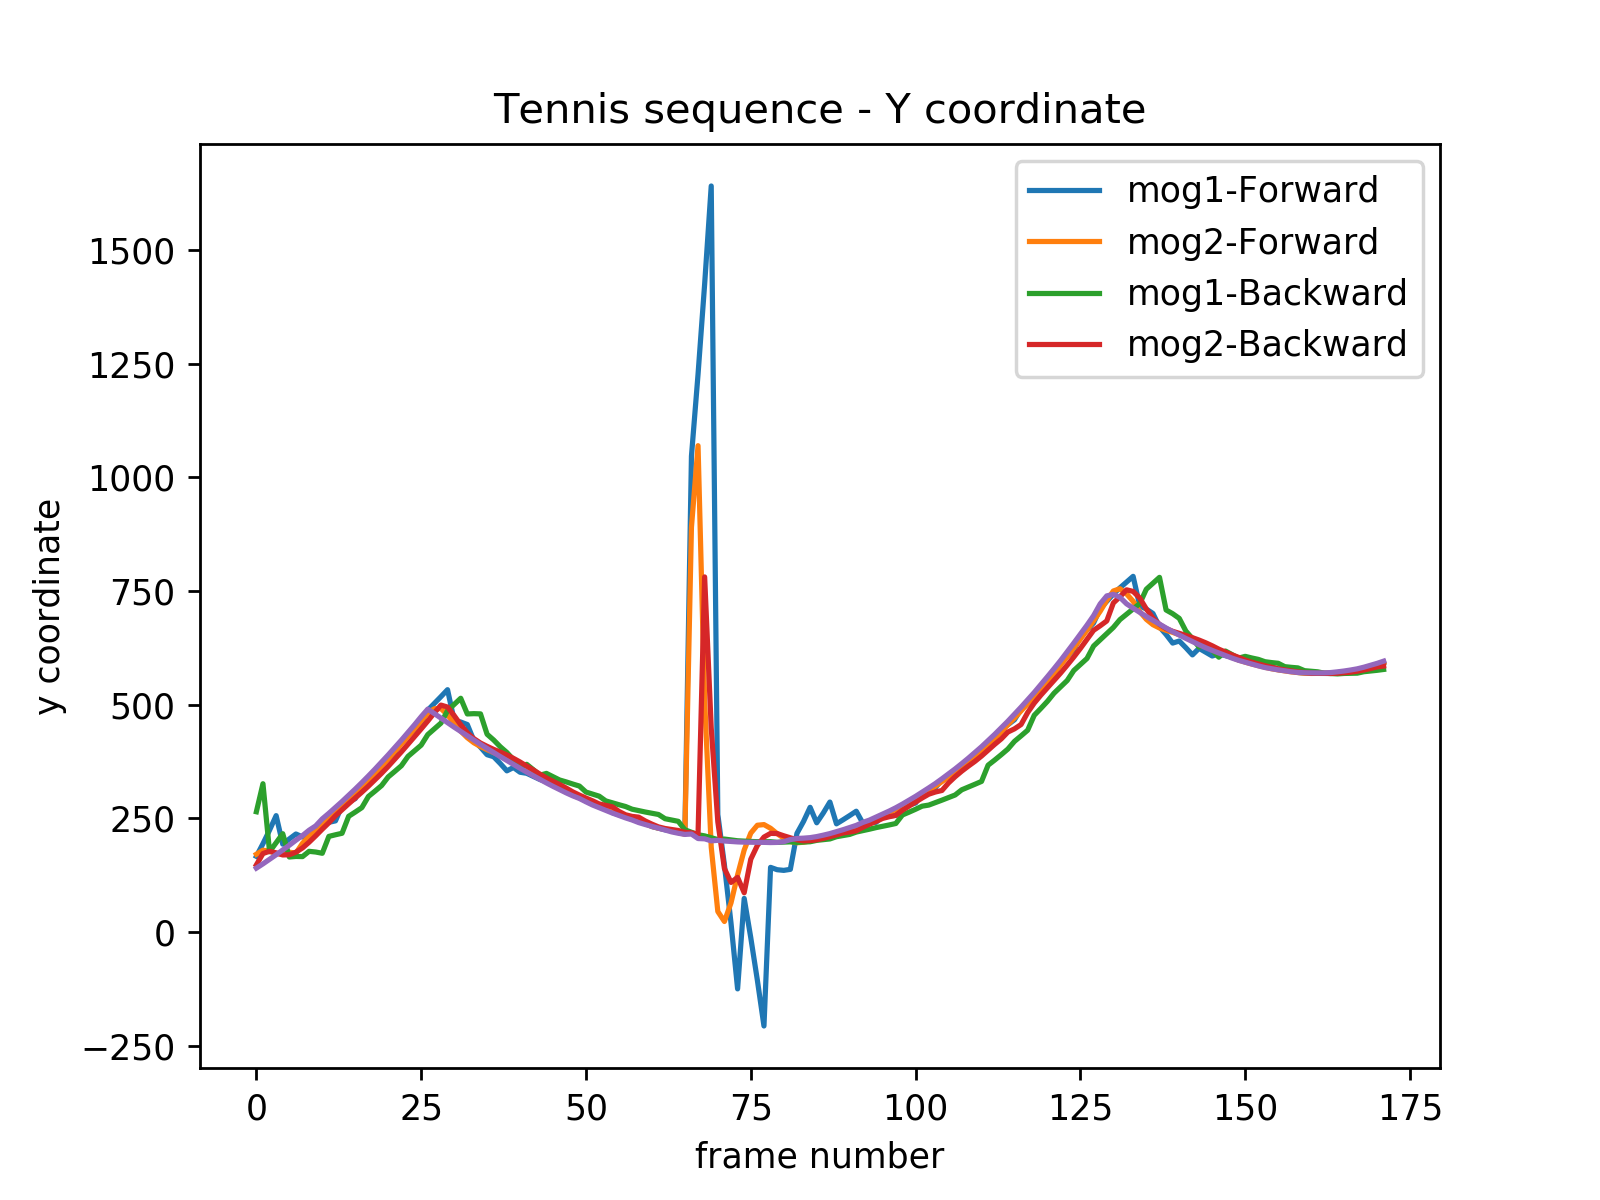

Text(0.5,0,'frame number')

In [356]:
_backwardF = _backwardDf[7:]
_forwardF = _forwardDf[7:]
plt.figure()

x_y = np.concatenate(_forwardF['mog_1'].values).reshape(len(_forwardF['mog_1'].values), 2)
plt.plot(x_y[:,1], label='mog1-Forward')

x_y = np.concatenate(_forwardF['mog_2'].values).reshape(len(_forwardF['mog_2'].values), 2)
plt.plot(x_y[:,1], label='mog2-Forward')

x_y = np.concatenate(_backwardF['mog_1'].values).reshape(len(_backwardF['mog_1'].values), 2)
plt.plot(x_y[:,1], label='mog1-Backward')

x_y = np.concatenate(_backwardF['mog_2'].values).reshape(len(_backwardF['mog_2'].values), 2)
plt.plot(x_y[:,1], label='mog2-Backward')

x_y_gt = np.concatenate(_backwardF['GT'].values).reshape(len(_backwardF['GT'].values), 2)

plt.title('Tennis sequence - Y coordinate')
plt.plot(x_y_gt[:,1])
plt.legend()
plt.ylabel('y coordinate')
plt.xlabel('frame number')